## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix, hstack, vstack

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC

pd.set_option('display.max_columns', None)
# from google.colab import files
# import warnings
# warnings.filterwarnings('ignore')

RANDOM_STATE = 0

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Рассмотрим датасет поближе

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2098 non-null   int64 
 1   description  2098 non-null   object
 2   object_img   2098 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 49.3+ KB


## Добавим новых признаков

In [4]:
# объеденим train и test
df_all = pd.concat([df_train, df_test])

In [5]:
df_all["len_description"] = df_all.description.map(len)

In [6]:
df_all["object"] = df_all["description"].map(lambda x : x.split()[0])

In [7]:
pattern = r'[а-яa-z0-9]+'
df_all["object"] = df_all["object"].str.lower().str.findall(pattern).str.join(' ')

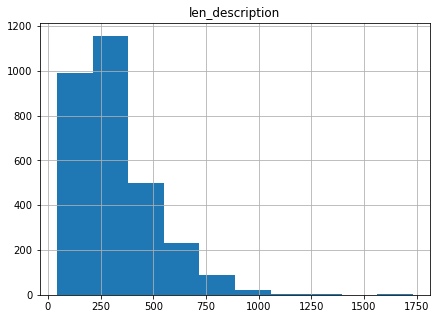

In [8]:
_ = df_all[['len_description']].hist(figsize=(7, 5))

In [9]:
df_all['len_description'] = np.log(df_all['len_description'], where=df_all['len_description']!=0)

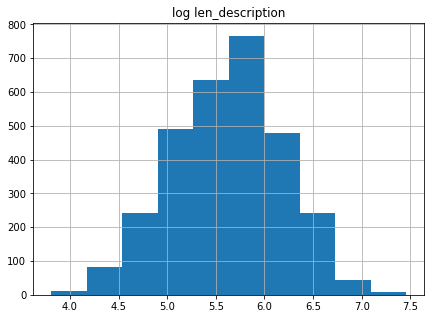

In [10]:
_ = df_all[['len_description']].hist(figsize=(7, 5))
plt.title('log len_description');

In [11]:
# one-hot кодирование
df_all = pd.get_dummies(df_all, columns=["object"])

In [12]:
%%time
tfidf_chars = TfidfVectorizer(analyzer='char_wb', max_features=30000, ngram_range=(3, 10), min_df=5, max_df=0.8)
tfidf_words = TfidfVectorizer(ngram_range=(1, 4), min_df=5, max_df=0.8)
csr_chars = tfidf_chars.fit_transform(df_all['description'])
csr_words = tfidf_words.fit_transform(df_all['description'])

Wall time: 12.5 s


## Выделим выборки

In [13]:
csr_all = hstack([csr_matrix(df_all.drop(["description","object_img",'id'], axis=1).values), 
                  csr_chars, csr_words])

X = csr_all[:df_train.shape[0]]
y = df_train['object_img']

test = csr_all[df_train.shape[0]:]

In [14]:
size_one_bin = 30
count_bins = int(np.ceil(y.max() / size_one_bin))
y_clf = pd.cut(y, bins=count_bins).rank(method='dense').astype(int) 

## Работа с моделью и оценка точности

In [15]:
%%time

reg_1 = MultinomialNB(alpha=0.0001)
reg_2 = LinearSVC(max_iter=3000)

# если size_one_bin == 1, т.е. не делить на кластеры, то можно использовать связку:
# reg_1 = MultinomialNB(alpha=0.0001)
# reg_2 = SVC()

r2_scores = []
r2_scores_reg_1 = []
r2_scores_reg_2 = []
n_folds = 3


cnt = 0
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

for train_ix, test_ix in tqdm(kfold.split(X, y_clf)):
    cnt += 1
    print(f'>Fold {cnt} of {n_folds}, size train: {train_ix.shape[0]}, size test: {test_ix.shape[0]},\
            % test: {np.round(test_ix.shape[0] / X.shape[0] * 100, 1)} %')
    
    X_train = X[train_ix, :]
    y_train = y_clf.loc[train_ix]
       
    X_test = X[test_ix, :]
    y_test = y.loc[test_ix]
    
    reg_1.fit(X_train, y_train)
    pred_1 = np.abs(reg_1.predict(X_test)) * size_one_bin
    
    r2_reg_1 = r2_score(y_test, pred_1)
    r2_scores_reg_1.append(np.round(r2_reg_1, 3))
    
    reg_2.fit(X_train, y_train)
    pred_2 = np.abs(reg_2.predict(X_test)) * size_one_bin
    
    r2_reg_2 = r2_score(y_test, pred_2)
    r2_scores_reg_2.append(np.round(r2_reg_2, 3))
    
    pred_stack = (pred_1 + pred_2) / 2
    r2_stack = r2_score(y_test, pred_stack)
    r2_scores.append(np.round(r2_stack, 3))

print(f'R2 {reg_1.__class__.__name__} (std): %.3f (%.3f),' % (np.mean(r2_scores_reg_1), np.std(r2_scores_reg_1)), 
      'folds:', r2_scores_reg_1)
print(f'R2 {reg_2.__class__.__name__} (std): %.3f (%.3f),' % (np.mean(r2_scores_reg_2), np.std(r2_scores_reg_2)), 
      'folds:', r2_scores_reg_2)

print('R2 stack (std): %.3f (%.3f),' % (np.mean(r2_scores), np.std(r2_scores)), 'folds:', r2_scores)

0it [00:00, ?it/s]

>Fold 1 of 3, size train: 1398, size test: 700,            % test: 33.4 %


1it [01:20, 80.02s/it]

>Fold 2 of 3, size train: 1399, size test: 699,            % test: 33.3 %


2it [02:38, 78.83s/it]

>Fold 3 of 3, size train: 1399, size test: 699,            % test: 33.3 %


3it [04:05, 81.68s/it]

R2 MultinomialNB (std): 0.975 (0.005), folds: [0.97, 0.972, 0.982]
R2 LinearSVC (std): 0.983 (0.002), folds: [0.98, 0.983, 0.986]
R2 stack (std): 0.983 (0.004), folds: [0.979, 0.982, 0.988]
Wall time: 4min 5s


## Обучение на всех данных

In [16]:
%%time
display(reg_1)
reg_1.fit(X, y_clf)
pred_1 = np.abs(reg_1.predict(test)) * size_one_bin

MultinomialNB(alpha=0.0001)

Wall time: 1.33 s


In [17]:
%%time
display(reg_2)
reg_2.fit(X, y_clf)
pred_2 = np.abs(reg_2.predict(test)) * size_one_bin

LinearSVC(max_iter=3000)

Wall time: 2min 6s


In [18]:
pred_stack = (pred_1 + pred_2) / 2

y_pred = pd.Series(data=pred_stack.astype(int), index=df_test['id'], name='object_img')
pred_ = y_pred.sort_values()
for i in range(len(pred_)):
    while pred_.iloc[i-1] == pred_.iloc[i]:
        pred_.iloc[i] += 1
        pred_.sort_values(inplace=True)

In [19]:
sub = df_test[['id']]
sub_ = sub.merge(pred_.reset_index(), how='left', on='id')

In [20]:
sub_.to_csv('submit.csv', index=False)